<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/done_all_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend --upgrade

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


In [506]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank

In [102]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [103]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [104]:
data.head(2)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


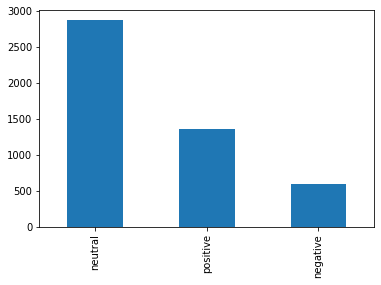

In [105]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [107]:
X= data.sentence
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=60, test_size=0.2, stratify=y)
print("Distribution of sentiments in train data\n",  y_train.value_counts().reset_index().values)
print()
print("Distribution of sentiments in test data\n", y_test.value_counts().reset_index().values)

Distribution of sentiments in train data
 [['neutral' 2303]
 ['positive' 1090]
 ['negative' 483]]

Distribution of sentiments in test data
 [['neutral' 575]
 ['positive' 273]
 ['negative' 121]]


## BiLSTM Model

### Preparing data to feed in model 

In [108]:
X_train.iloc[0]

'For the new shares subscribed with stock options all shareholder rights commence from the date on which they are entered into the Trade Register .'

In [109]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [110]:
print("Sequences --> ", X_train[0])

print("Original sentence all lower cased \n", " ".join([tokenizer.index_word.get(i) for i in X_train[0]]))

Sequences -->  [7, 1, 48, 69, 814, 17, 128, 668, 119, 924, 264, 3079, 13, 1, 715, 14, 60, 251, 44, 992, 160, 1, 371, 716]
Original sentence all lower cased 
 for the new shares subscribed with stock options all shareholder rights commence from the date on which they are entered into the trade register


In [111]:
print("Sequences length sample 1:", len(X_train[0])," sample 2:", len(X_train[1]))
print("Max length of sequence is ", np.max([len(X_train[i]) for i in range(len(X_train))]))

Sequences length sample 1: 24  sample 2: 30
Max length of sequence is  71


In [112]:
# Make sequences of equal length 
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [113]:
print("After padding 1st sample became \n", X_train[0])

After padding 1st sample became 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    7    1   48   69  814   17  128  668  119
  924  264 3079   13    1  715   14   60  251   44  992  160    1  371
  716]


In [114]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train = to_categorical(le.transform(y_train))
y_test = to_categorical(le.transform(y_test))

### Model Building

In [115]:
n_classes = y_train.shape[1]

In [116]:
EMBEDDING_DIM = 300
VOCAB_SIZE = len(tokenizer.word_index)

model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 300)           2710500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 71, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 71, 400)           801600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 71, 400)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                20050     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)               

In [117]:
# plot_model(model)

In [118]:
#Train Model

batch_size = 64
epochs = 10

model.fit(X_train, y_train, batch_size=batch_size, verbose=1, epochs=epochs)

Epoch 1/10
61/61 [==============================] - 4s 22ms/step - loss: 0.9752 - accuracy: 0.5415
Epoch 2/10
61/61 [==============================] - 1s 22ms/step - loss: 0.7589 - accuracy: 0.6848
Epoch 3/10
61/61 [==============================] - 1s 22ms/step - loss: 0.5807 - accuracy: 0.7560
Epoch 4/10
61/61 [==============================] - 1s 22ms/step - loss: 0.4634 - accuracy: 0.8019
Epoch 5/10
61/61 [==============================] - 1s 22ms/step - loss: 0.3383 - accuracy: 0.8745
Epoch 6/10
61/61 [==============================] - 1s 22ms/step - loss: 0.2074 - accuracy: 0.9358
Epoch 7/10
61/61 [==============================] - 1s 22ms/step - loss: 0.1298 - accuracy: 0.9581
Epoch 8/10
61/61 [==============================] - 1s 22ms/step - loss: 0.1126 - accuracy: 0.9611
Epoch 9/10
61/61 [==============================] - 1s 22ms/step - loss: 0.0624 - accuracy: 0.9809
Epoch 10/10
61/61 [==============================] - 1s 22ms/step - loss: 0.0500 - accuracy: 0.9868


In [119]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Testing Accuracy : {:.2f}".format(test_acc * 100))

Testing Accuracy : 75.95


In [120]:
preds = model.predict(X_test, batch_size=batch_size)
true_y = np.argmax(y_test, axis=1)
pred_y = np.argmax(preds, axis=1)

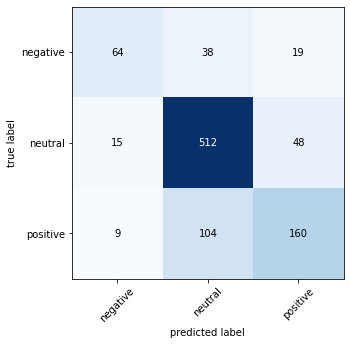

In [121]:
c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

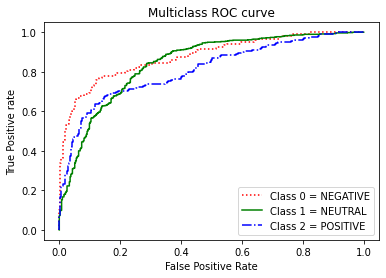

In [122]:
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(y_test, axis=1), preds[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle=':',color='red', label='Class 0 = NEGATIVE')
plt.plot(fpr[1], tpr[1], linestyle='-',color='green', label='Class 1 = NEUTRAL')
plt.plot(fpr[2], tpr[2], linestyle='-.',color='blue', label='Class 2 = POSITIVE ')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

# Prepare NEPSE DATA

In [372]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)

In [373]:
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']

In [374]:
indices['date'] = pd.to_datetime(indices['date'])

In [375]:
indices = indices[indices['date'] < '2019-07-06']

In [376]:
indices.shape

(1248, 5)

In [385]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']

In [386]:
news_df = news_df[['date', 'content']].groupby('date')['content'].apply(lambda content: " ".join(content))

In [393]:
news_df = news_df[news_df.index.isin(indices['date'])]

In [396]:
indices = indices[indices['date'].isin(news_df.index)]

In [403]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [440]:
full_df = pd.concat([news_df.reset_index(), indices[['index', 'pct_change']].reset_index(drop=True)], axis=1)

In [441]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [442]:
news_sentiments = prepare_and_predict_news(full_df['content'], pad_max_len=max_len, batch_size=batch_size)

In [443]:
sentiment_df = pd.DataFrame(news_sentiments, columns=['negative', 'neutral','positive'])

In [445]:
df_with_sentiment = pd.concat([full_df, sentiment_df], axis=1)

In [451]:
df_with_sentiment['target'] = np.where(df_with_sentiment['pct_change'] < 0 , 0, 1)

In [453]:
validation_df = df_with_sentiment[df_with_sentiment['date'] > '2018-12-31']
train_df = df_with_sentiment[df_with_sentiment['date'] <= '2018-12-31']

In [455]:
features = ['negative', 'neutral', 'positive']
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['target'], shuffle=False, random_state=60, test_size=0.2 )

In [456]:
X_train.shape, X_test.shape

((893, 3), (224, 3))

In [461]:
y_test

893     0
894     0
895     1
896     1
897     1
       ..
1112    0
1113    0
1114    1
1115    0
1116    0
Name: target, Length: 224, dtype: int64

In [466]:
import xgboost as xgb
params = {
    'learning_rate': 0.001,
    'max_depth': 2, 
    'tree_method': 'gpu_hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc', 
    'tree_method': 'gpu_hist', 
    'random_state': 60,
}
dtrain = xgb.DMatrix(X_train, y_train, feature_names=features)
dval = xgb.DMatrix(X_test, y_test,feature_names = features)
model = xgb.train(params, dtrain,num_boost_round=500, 
        evals=[(dtrain, 'train'),(dval, 'eval')],
        early_stopping_rounds=100, verbose_eval=100)
val_pred = model.predict(dval, ntree_limit = model.best_ntree_limit)

[0]	train-auc:0.546139	eval-auc:0.456538
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[100]	train-auc:0.564933	eval-auc:0.473652
Stopping. Best iteration:
[90]	train-auc:0.564933	eval-auc:0.473652



In [467]:
score = roc_auc_score(y_test, val_pred)
print(score)

0.47365180989903966


In [495]:
params = {
'num_leaves': 4,
'min_child_weight': 0.5,
'feature_fraction': 1,
'bagging_fraction':0.9,
# 'min_data_in_leaf': 106,
'objective': 'binary',
'max_depth': 4,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
'random_state': 60
}


In [496]:
%%time
import lightgbm as lgb
tr_data = lgb.Dataset(X_train, label=y_train)
va_data = lgb.Dataset(X_test, label=y_test)

model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,   
        feature_name=features,
        verbose_eval=10
    )

Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.60219	valid_1's auc: 0.506279
[20]	training's auc: 0.618869	valid_1's auc: 0.484404
[30]	training's auc: 0.640129	valid_1's auc: 0.443446
[40]	training's auc: 0.64864	valid_1's auc: 0.444472
[50]	training's auc: 0.654621	valid_1's auc: 0.457687
Early stopping, best iteration is:
[5]	training's auc: 0.577105	valid_1's auc: 0.51933
CPU times: user 66.7 ms, sys: 2.75 ms, total: 69.5 ms
Wall time: 20.6 ms


In [501]:
np.where(model.predict(validation_df[features]) > 0.51, 1,0 )

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [514]:
validation_df['preds'] = np.where(model.predict(validation_df[features]) > 0.5, 1,0 )

In [515]:
accuracy_score(validation_df['target'], validation_df['preds'])

0.48760330578512395

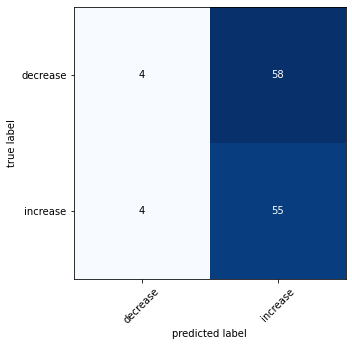

In [519]:
cm = confusion_matrix(validation_df['target'], validation_df['preds'])
plot_confusion_matrix(cm, cmap='Blues', class_names = ['decrease', 'increase'], figsize=(5, 5))
plt.show()

In [520]:
from sklearn.metrics import precision_recall_fscore_support
p, r, f1, s = precision_recall_fscore_support(validation_df['target'], validation_df['preds'], average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, \
'3-F1 score': f1, '4-Support': s}, index=['decrease', 'increase'])
# Print precision, recall, f1 score and support
print(results.round(decimals=3))


          1-Precision  2-Recall  3-F1 score  4-Support
decrease        0.500     0.065       0.114         62
increase        0.487     0.932       0.640         59


In [ ]:
imdb_train, ds_info = tfds.load(name="imdb_reviews", split="train", 
                                with_info=True, as_supervised=True)
imdb_test = tfds.load(name="imdb_reviews", split="test", 
                      as_supervised=True)

In [ ]:
imdb_train = tfds.as_dataframe(imdb_train, ds_info)
imdb_test = tfds.as_dataframe(imdb_test, ds_info)

In [ ]:
imdb_train = imdb_train.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
imdb_test = imdb_test.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [ ]:
X_train = imdb_train['text']
y_train = imdb_train['label']
X_test = imdb_test['text']
y_test = imdb_test['label']

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test= tokenizer.texts_to_sequences(X_test)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])

In [ ]:
Tokenizer()

In [ ]:
X_train = pad_sequences(X_train, maxlen=150, padding='post', )
X_test = pad_sequences(X_test, maxlen = 150, padding='post')

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
n_classes = 1
def build_model_lstm(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
    mask_zero=True),
    tf.keras.layers.LSTM(rnn_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model



In [ ]:
vocab_size = len(word_index) +1
# The embedding dimension
embedding_dim = 64
# Number of RNN units
rnn_units = 64
# batch size
BATCH_SIZE=100
model = build_model_lstm(
    vocab_size = vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          5669312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,702,401
Trainable params: 5,702,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])

model.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, verbose=1)


Epoch 1/10
250/250 [==============================] - 13s 42ms/step - loss: 0.5405 - accuracy: 0.7022 - precision: 0.7034 - recall: 0.7006
Epoch 2/10
250/250 [==============================] - 11s 42ms/step - loss: 0.1774 - accuracy: 0.9366 - precision: 0.9344 - recall: 0.9400
Epoch 3/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0855 - accuracy: 0.9739 - precision: 0.9753 - recall: 0.9726
Epoch 4/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0499 - accuracy: 0.9856 - precision: 0.9844 - recall: 0.9867
Epoch 5/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0265 - accuracy: 0.9928 - precision: 0.9938 - recall: 0.9919
Epoch 6/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0303 - accuracy: 0.9909 - precision: 0.9922 - recall: 0.9897
Epoch 7/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0358 - accuracy: 0.9872 - precision: 0.9885 - recall: 0.9856
Epoch 8/10
250/250 [=======

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 3s 7ms/step - loss: 0.8269 - accuracy: 0.8362 - precision: 0.8356 - recall: 0.8370


[0.826852023601532, 0.8361600041389465, 0.8355693817138672, 0.8370400071144104]

In [ ]:
model.predict(X_test[0])

0.47636515299479165

In [ ]:
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [ ]:
EMBEDDING_DIM = 300
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2493, 300)         26574900  
_________________________________________________________________
dropout (Dropout)            (None, 2493, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2493, 400)         801600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2493, 400)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                20050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [ ]:
batch_size = 64
epochs = 10
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=1)

Epoch 1/10
391/391 [==============================] - 35s 91ms/step - loss: 0.2858 - accuracy: 0.8836
Epoch 2/10
391/391 [==============================] - 35s 90ms/step - loss: 0.2051 - accuracy: 0.9219
Epoch 3/10
391/391 [==============================] - 35s 90ms/step - loss: 0.1554 - accuracy: 0.9426
Epoch 4/10
391/391 [==============================] - 35s 90ms/step - loss: 0.1183 - accuracy: 0.9592
Epoch 5/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0844 - accuracy: 0.9712
Epoch 6/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0571 - accuracy: 0.9808
Epoch 7/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0411 - accuracy: 0.9863
Epoch 8/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0280 - accuracy: 0.9912
Epoch 9/10
391/391 [==============================] - 35s 91ms/step - loss: 0.0179 - accuracy: 0.9943
Epoch 10/10
391/391 [==============================] - 35s 91ms/step - loss: 0.012

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 4s 13ms/step - loss: 0.6060 - accuracy: 0.8502


[0.6059731841087341, 0.8501999974250793]

In [ ]:
model.predict(X_test[0])

array([[3.94611120e-01, 6.05388880e-01],
       [7.62499988e-01, 2.37499967e-01],
       [9.99360025e-01, 6.39992417e-04],
       [2.54454720e-03, 9.97455418e-01],
       [2.42744815e-02, 9.75725532e-01],
       [5.18489957e-01, 4.81509984e-01],
       [1.93062499e-01, 8.06937516e-01],
       [8.01742554e-01, 1.98257491e-01],
       [6.38091326e-01, 3.61908704e-01],
       [4.71223384e-01, 5.28776646e-01],
       [8.80347371e-01, 1.19652607e-01],
       [3.91476555e-04, 9.99608576e-01],
       [9.98337388e-01, 1.66256400e-03],
       [3.48617882e-01, 6.51382089e-01],
       [5.72086036e-01, 4.27913964e-01],
       [9.84464467e-01, 1.55354915e-02],
       [1.09254186e-04, 9.99890685e-01],
       [1.99941069e-01, 8.00058901e-01],
       [8.08977187e-01, 1.91022769e-01],
       [5.03213584e-01, 4.96786386e-01],
       [8.48092139e-01, 1.51907936e-01],
       [9.69207048e-01, 3.07929907e-02],
       [5.03213584e-01, 4.96786386e-01],
       [8.48092139e-01, 1.51907936e-01],
       [6.921743